In [22]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numba
from numba import jit, int32, int64, float32, float64
import timeit
import time
import pstats

### Implementation 

In [23]:
@jit(nopython = True)
def p_ij(d_matrix, perplexity = 40.0, tol = 1e-6):
    """
    Finds P_ij matrix using binary search to find value of sigma_i

    Inputs: d_matrix- np.array of pairwise distance matrix, with a fixed perplexity

    Output: P-ij matrix
    """

    (n, d) = d_matrix.shape

    P = np.zeros((n, d), dtype=np.float64)
    prec_sum = 0.0    
    
    # precision = 1/2sigma^2
    for i in range(n):
        prec_min = -np.inf
        prec_max = np.inf
        prec = 1.0

        # implement binary search for optimal sigmas 
        for j in range(10): # 10 binary search steps
            sum_p = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = np.exp(-d_matrix[i, k] * prec)
                    sum_p += P[i, k]

            sum_p_distribution = 0.0

            for k in range(d):
                P[i, k] /= (sum_p + 1e-8)
                sum_p_distribution += d_matrix[i, k] * P[i, k]

            # Calculate entropy, H matrix
            H = np.log(sum_p) + prec * sum_p_distribution
            H_diff = H - np.log(perplexity)

            
            # check if entropy is within tolerance
            if np.fabs(H_diff) <= tol:
                break

            if H_diff > 0.0:
                prec_min = prec
                if prec_max == np.inf:
                    prec *= 2.0
                else:
                    prec = (prec + prec_max) / 2.0
            else:
                prec_max = prec
                if prec_min == -np.inf:
                    prec /= 2.0
                else:
                    prec = (prec + prec_min) / 2.0

        prec_sum += prec

    return P


@jit(nopython = True)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    n = X.shape[0]
    d = X.shape[1]
    D = np.empty((n, n), dtype=np.float64)
    
    for i in range(n):
        for j in range(n):
            dist = 0.0
            for k in range(d):
                diff = X[i, k] - X[j, k]
                dist += diff * diff
            D[i, j] = dist
        
    return np.asarray(D)




@jit(nopython = True)
def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q

@jit(nopython = True)
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    
    pq_diff = np.expand_dims((P - Q), 2)
    
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    
    y_dist = np.expand_dims(np.power(1 + squared_euc_dist(Y), -1), 2)

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


@jit(nopython = True)
def tsne_opt(X, num_iters = 1000, perplexity = 40, alpha = 100, momentum = 0.8):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

In [24]:
# plot code
def tsne_plot(Y, labels):
    '''
    '''
    plt.figure(figsize=(9.6,7.2))
    df = pd.DataFrame(data=np.c_[Y, labels], columns=("x", "y", "label"))
    l = len(set(labels))
    
    if l <= 5:
        sns.scatterplot(data = df, x = "x", y = "y", hue = "label", palette = sns.color_palette("husl", l)).set(xlabel=None, ylabel=None)
    
    elif l <= 20:
        sns.scatterplot(data = df, x = "x", y = "y", hue = "label", palette = sns.color_palette("husl", l)).set(xlabel=None, ylabel=None)
        plt.legend(bbox_to_anchor=(1.03, 1), borderaxespad=0)
    
    else:
        sns.scatterplot(data = df, x = "x", y = "y", hue = "label", palette = sns.color_palette("husl", l)).set(xlabel=None, ylabel=None)
        plt.legend(bbox_to_anchor=(1.03, 1), borderaxespad=0, ncol=2)

    plt.show()

In [25]:
# PCA function code
def pca(X):
    train = StandardScaler().fit_transform(X)
    out = PCA(n_components=50).fit_transform(train)
    return out

## Examples from Paper

### MNist Data (1000 Rows)

In [26]:
X = np.loadtxt("Data/mnist2500_X.txt")
labels = np.loadtxt("Data/mnist2500_labels.txt")[:1000]
small = X[:1000]
small.shape

(1000, 784)

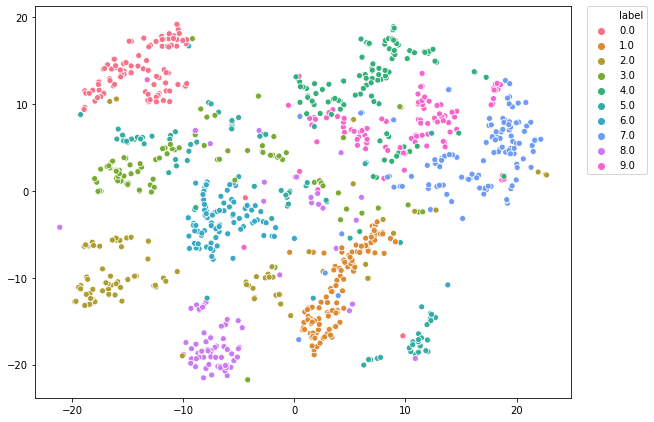

In [27]:
yout = tsne_opt(small)
tsne_plot(yout, labels)

### Olivetti Faces Data

In [28]:
# Imports
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
import scipy.io

# Download Olivetti faces dataset
olivetti = fetch_olivetti_faces()

In [29]:
# initialize X by reducing to 50 dimensions using PCA
pca_olivetti = pca(olivetti.data)

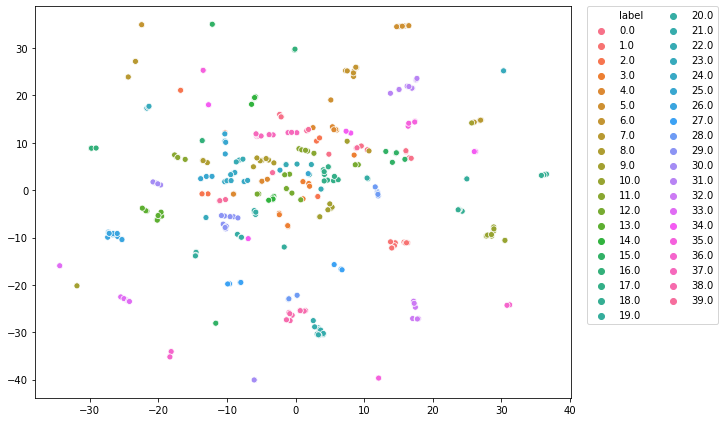

In [30]:
olivetti_out = tsne_opt(pca_olivetti)
tsne_plot(olivetti_out, olivetti.target)

### Coil-20 Data

In [31]:
mat = scipy.io.loadmat("Data/COIL20.mat")
coil20 = mat['X']
coil20_labels = mat['Y'][:, 0]
pca_coil = pca(coil20)

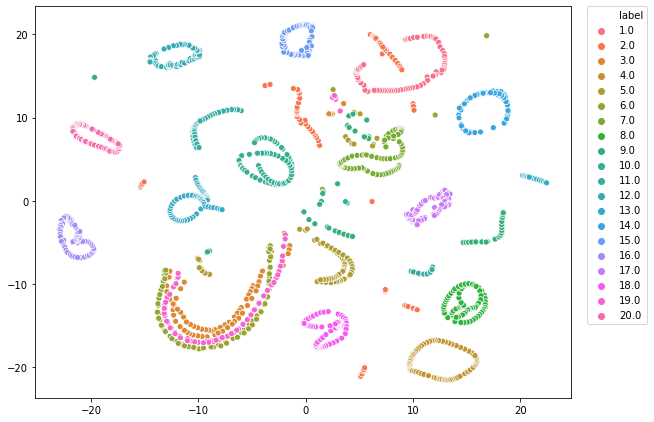

In [32]:
coil20_out = tsne_opt(pca_coil)
tsne_plot(coil20_out, coil20_labels)

## Other Real Data Examples

### Iris Data

In [33]:
iris = sns.load_dataset('iris')
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
specs = np.array(iris['species'])

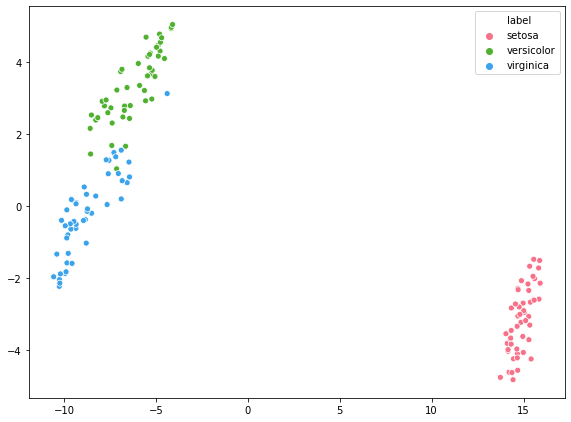

In [34]:
yout = tsne_opt(X)
tsne_plot(yout, specs)

### Breast Cancer Data

In [35]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

breast = load_breast_cancer()
breast_data = breast.data
breast_labels = breast.target
X = breast_data
y = breast.target

X = StandardScaler().fit_transform(X)

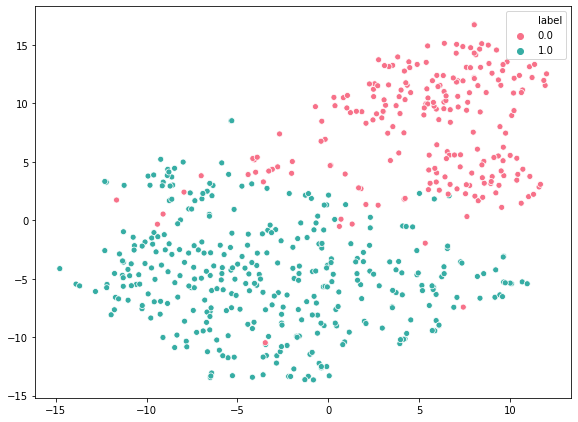

In [36]:
yout = tsne_opt(X)
tsne_plot(yout, y)

### RNA Sequence Data

In [37]:
rna = pd.read_csv('Data/rna_data.csv')
X = np.array(rna.iloc[:, 1:]).astype(np.float)
y = pd.read_csv('Data/rna_labels.csv')
y = np.array(y).squeeze()
X = pca(X)

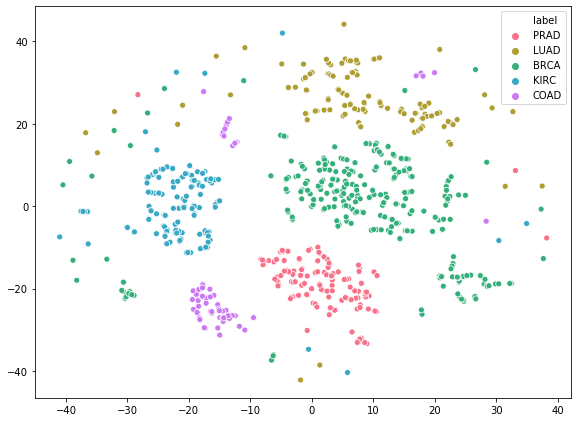

In [38]:
yout = tsne_opt(X)
tsne_plot(yout, y)